In [1]:
from keras.preprocessing.image import ImageDataGenerator


In [2]:
import keras
import tensorflow as tf

In [3]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

In [4]:
from keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model

In [5]:
from tensorflow.keras.optimizers import SGD

In [6]:
import matplotlib.pyplot as plt 
import time

## data Inputs


In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_dataset = ImageDataGenerator(rescale=1./255)
test_dataset = ImageDataGenerator(rescale=1./255)
validation_dataset = ImageDataGenerator(rescale=1./255)


#BATCH_SIZE = 32
#IMG_SIZE = (160, 160)
#train_dir='Database/Train/'
#validation_dir='Database/Valid/'
#train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            #shuffle=True,
                                                            #batch_size=BATCH_SIZE,
                                                            #image_size=IMG_SIZE)
#validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                # shuffle=True,
                                                                # batch_size=BATCH_SIZE,
                                                                 #image_size=IMG_SIZE)
#import tensorflow as tf
#AUTOTUNE = tf.data.AUTOTUNE

#train_dataset= train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_datagen = test_datagen.prefetch(buffer_size=AUTOTUNE)
 
batchsize = 10
train_generator=train_dataset.flow_from_directory('Database/Train/', 
                                                  target_size=(224, 224), 
                                                  batch_size=batchsize, 
                                                  class_mode='categorical')
 
validation_generator = validation_dataset.flow_from_directory('Database/Valid',
        target_size=(224, 224),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
test_generator = test_dataset.flow_from_directory('Database/Test/',
       target_size=(224, 224),
       batch_size=batchsize,
       class_mode='categorical',
       shuffle=False)

Found 360 images belonging to 2 classes.
Found 93 images belonging to 2 classes.
Found 223 images belonging to 2 classes.


## Model Creation

##### VGG Net: VGG network has simplest structure with 3 x 3 filter in each convolutional layer. There are two variant available VGG-16 and VGG1-9. In the image above VGG network is presneted.


##### Transfer Learning: The VGGNet pre-trained on ImageNet and Inception module for transfer learning, and trained the newly formed neural networks using new datasets. The approach combines the advantages of the VGGNet and Inception module.

In [8]:
#VGG19
base_model1=keras.applications.vgg19.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#MobileNet
base_model2=tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#ResNet50 
base_model3 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax')



#VGG16
base_model4=keras.applications.vgg16.VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax')



In [10]:
base_model1.summary()
base_model2.summary()
base_model3.summary()
base_model4.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## setting all layers as non-trainable

In [12]:
for layer in base_model1.layers:
    layer.trainable = False
    
for layer in base_model2.layers:
    layer.trainable = False 
    
for layer in base_model3.layers:
    layer.trainable = False
    
for layer in base_model4.layers:
    layer.trainable = False

### Defining custom activation function

As per the paper, custom activation function Swish is used in place of Relu in the model.

In [13]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

## Defining convolution batch normalization function with Swish activation

In [14]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1)):   
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides)(x)
    x = Lambda(swish)(x)
    x = BatchNormalization(axis=3)(x)  
    return x  

## Defining Inception Block:

Inception Modules are used in Convolutional Neural Networks to allow for more efficient computation and deeper Networks through a dimensionality reduction with stacked 1×1 convolutions. The modules were designed to solve the problem of computational expense, as well as overfitting, among other issues.

In [15]:
def Inception(x,nb_filter):  
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
  
    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1))  
  
    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
  
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)  
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1))  
  
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)    
    return x

## Adding new layers in model architechture

## Global Average Pooling

Fully connected layers are replaced by a global pooling layer to conduct the dimension reduction of feature maps.

In [16]:
# MODEL 1- VGG19

x = base_model1.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_1 = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions_1)


In [17]:
# MODEL 2 MobileNet

x = base_model2.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_2 = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions_2)


In [18]:
 #ResNet50
x = base_model3.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_3 = Dense(2, activation='softmax')(x)
model3 = Model(inputs=base_model3.input, outputs=predictions_3)

In [19]:
#VGG-16
x = base_model4.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_4 = Dense(2, activation='softmax')(x)
model4 = Model(inputs=base_model4.input, outputs=predictions_4)

In [20]:
model1.summary()
model2.summary()
model3.summary()
model4.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## Compiling the models

In [28]:
def comp():
    learning_rate=0.0001
    decay=1e-6
    momentum=0.8
    nesterov=True
    sgd_optimizer= SGD(lr = learning_rate, decay = decay, momentum = momentum, nesterov = nesterov)
    models=['VGG-19','MobileNet','ResNet','VGG-16']
    
    for i in models:
        if i=='VGG-19':
            model1.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        elif i=='MobileNet':
            model2.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        elif i=='ResNet':
            model3.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        else:
            model4.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        
if __name__ == "__main__":
    comp()

## Training the Models

In [38]:
def train():
    epochs=2
    batch_size=10
    models=['VGG-19','MobileNet','ResNet','VGG-16']
    for i in range(len(models)):
        if models[i]=='VGG-19':
            start=time.time()
            history_1=model1.fit(
                              train_generator,
                              steps_per_epoch=train_generator.samples/train_generator.batch_size ,
                              epochs=epochs, batch_size =batch_size,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples/validation_generator.batch_size,
                              verbose=1)
            end=time.time()
            print("Execution time : ",(end-start))
    return

train()

Epoch 1/2
36/36 [==============================] - 113s 3s/step - loss: 0.5650 - accuracy: 0.7139 - mse: 0.1902 - val_loss: 0.6935 - val_accuracy: 0.3226 - val_mse: 0.2502
Epoch 2/2
36/36 [==============================] - 116s 3s/step - loss: 0.4529 - accuracy: 0.8111 - mse: 0.1440 - val_loss: 0.7235 - val_accuracy: 0.2366 - val_mse: 0.2652
Execution time :  237.43849563598633


In [31]:
#Model1 VGG-19
import time
epochs =25
batch_size = 10

start = time.time()
history_1 = model1.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/25
36/36 [==============================] - 146s 4s/step - loss: 0.5871 - accuracy: 0.6806 - mse: 0.2004 - val_loss: 0.9125 - val_accuracy: 0.2366 - val_mse: 0.3557
Epoch 2/25
36/36 [==============================] - 147s 4s/step - loss: 0.4385 - accuracy: 0.8333 - mse: 0.1376 - val_loss: 1.1685 - val_accuracy: 0.2366 - val_mse: 0.4597
Epoch 3/25
36/36 [==============================] - 117s 3s/step - loss: 0.4038 - accuracy: 0.8139 - mse: 0.1261 - val_loss: 1.4209 - val_accuracy: 0.2366 - val_mse: 0.5394
Epoch 4/25
36/36 [==============================] - 118s 3s/step - loss: 0.4016 - accuracy: 0.8167 - mse: 0.1262 - val_loss: 1.6925 - val_accuracy: 0.2366 - val_mse: 0.6035
Epoch 5/25
36/36 [==============================] - 118s 3s/step - loss: 0.3509 - accuracy: 0.8556 - mse: 0.1068 - val_loss: 1.9919 - val_accuracy: 0.2366 - val_mse: 0.6537
Epoch 6/25
36/36 [==============================] - 120s 3s/step - loss: 0.3278 - accuracy: 0.8778 - mse: 0.0977 - val_loss: 2.2055 - v

In [32]:
#MobileNet
epochs =25
batch_size = 10
import time
start = time.time()
history_2 = model2.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/25
36/36 [==============================] - 22s 616ms/step - loss: 0.7250 - accuracy: 0.5389 - mse: 0.2634 - val_loss: 0.6823 - val_accuracy: 0.5914 - val_mse: 0.2446
Epoch 2/25
36/36 [==============================] - 22s 597ms/step - loss: 0.5067 - accuracy: 0.7611 - mse: 0.1664 - val_loss: 0.6385 - val_accuracy: 0.6667 - val_mse: 0.2238
Epoch 3/25
36/36 [==============================] - 22s 605ms/step - loss: 0.4180 - accuracy: 0.8194 - mse: 0.1296 - val_loss: 0.5714 - val_accuracy: 0.7527 - val_mse: 0.1926
Epoch 4/25
36/36 [==============================] - 22s 610ms/step - loss: 0.3628 - accuracy: 0.8861 - mse: 0.1074 - val_loss: 0.5061 - val_accuracy: 0.7849 - val_mse: 0.1642
Epoch 5/25
36/36 [==============================] - 22s 613ms/step - loss: 0.3374 - accuracy: 0.8889 - mse: 0.0983 - val_loss: 0.4371 - val_accuracy: 0.8172 - val_mse: 0.1360
Epoch 6/25
36/36 [==============================] - 22s 618ms/step - loss: 0.3114 - accuracy: 0.8833 - mse: 0.0899 - val_loss

In [33]:
#ResNet50
epochs =25
batch_size = 10
import time
start = time.time()
history_3 = model3.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/25
36/36 [==============================] - 39s 1s/step - loss: 0.6816 - accuracy: 0.6083 - mse: 0.2443 - val_loss: 0.7998 - val_accuracy: 0.2366 - val_mse: 0.3027
Epoch 2/25
36/36 [==============================] - 39s 1s/step - loss: 0.6566 - accuracy: 0.7306 - mse: 0.2318 - val_loss: 0.9063 - val_accuracy: 0.2366 - val_mse: 0.3529
Epoch 3/25
36/36 [==============================] - 39s 1s/step - loss: 0.6325 - accuracy: 0.7639 - mse: 0.2200 - val_loss: 1.0236 - val_accuracy: 0.2366 - val_mse: 0.4037
Epoch 4/25
36/36 [==============================] - 40s 1s/step - loss: 0.6125 - accuracy: 0.7611 - mse: 0.2103 - val_loss: 1.1443 - val_accuracy: 0.2366 - val_mse: 0.4509
Epoch 5/25
36/36 [==============================] - 40s 1s/step - loss: 0.5939 - accuracy: 0.7944 - mse: 0.2015 - val_loss: 1.2543 - val_accuracy: 0.2366 - val_mse: 0.4892
Epoch 6/25
36/36 [==============================] - 40s 1s/step - loss: 0.5797 - accuracy: 0.8083 - mse: 0.1948 - val_loss: 1.3294 - val_acc

In [34]:
#VGG-16
epochs =25
batch_size = 10
import time
start = time.time()
history_4 = model4.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/25
36/36 [==============================] - 103s 3s/step - loss: 0.6262 - accuracy: 0.6194 - mse: 0.2183 - val_loss: 0.7553 - val_accuracy: 0.2366 - val_mse: 0.2810
Epoch 2/25
36/36 [==============================] - 107s 3s/step - loss: 0.5153 - accuracy: 0.7833 - mse: 0.1682 - val_loss: 0.7932 - val_accuracy: 0.2366 - val_mse: 0.2995
Epoch 3/25
36/36 [==============================] - 109s 3s/step - loss: 0.4651 - accuracy: 0.8250 - mse: 0.1472 - val_loss: 0.8170 - val_accuracy: 0.2366 - val_mse: 0.3111
Epoch 4/25
36/36 [==============================] - 109s 3s/step - loss: 0.4075 - accuracy: 0.8750 - mse: 0.1232 - val_loss: 0.8146 - val_accuracy: 0.2366 - val_mse: 0.3099
Epoch 5/25
36/36 [==============================] - 109s 3s/step - loss: 0.3855 - accuracy: 0.8639 - mse: 0.1165 - val_loss: 0.7923 - val_accuracy: 0.2366 - val_mse: 0.2992
Epoch 6/25
36/36 [==============================] - 109s 3s/step - loss: 0.3459 - accuracy: 0.8778 - mse: 0.1014 - val_loss: 0.7371 - v

In [35]:
model1.save_weights('mix_1epochs.h5')
model2.save_weights('mix1_1epochs.h5')
model3.save_weights('mix1_1epochs.h5')
model4.save_weights('mix1_1epochs.h5')

<Figure size 432x288 with 0 Axes>

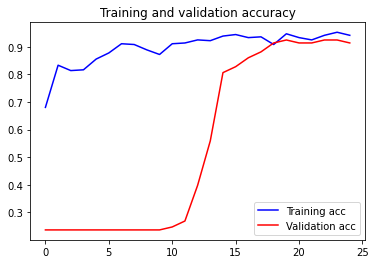

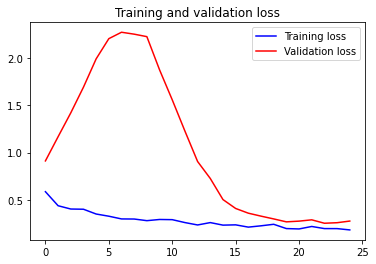

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt 
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('custom_trainvalacc.png')
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
#plt.show()
plt.savefig('custom_trainvalloss.png')
plt.figure()

In [43]:
import time
start=time.time()
test_output_1= model1.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model2.metrics_names)
print(test_output_1)
print("testing time : "+ str(end-start))

23/22 [==============================] - 37s 2s/step - loss: 0.4111 - accuracy: 0.8296 - mse: 0.1244
['loss', 'accuracy', 'mse']
[0.41112416982650757, 0.8295964002609253, 0.1244213804602623]
testing time : 38.413803815841675


In [41]:
start=time.time()
test_output_2= model2.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_2)
print("testing time : "+ str(end-start))

23/22 [==============================] - 5s 212ms/step - loss: 0.1821 - accuracy: 0.9327 - mse: 0.0540
['loss', 'accuracy', 'mse']
[0.18211065232753754, 0.9327354431152344, 0.05397707596421242]
testing time : 5.199057340621948


In [45]:
start=time.time()
test_output_3= model3.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_3)
print("testing time : "+ str(end-start))

23/22 [==============================] - 11s 494ms/step - loss: 0.4359 - accuracy: 0.8475 - mse: 0.1358
['loss', 'accuracy', 'mse']
[0.4359146058559418, 0.847533643245697, 0.13582256436347961]
testing time : 11.98839807510376


In [46]:
start=time.time()
test_output_4= model4.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_4)
print("testing time : "+ str(end-start))

23/22 [==============================] - 31s 1s/step - loss: 0.2716 - accuracy: 0.9103 - mse: 0.0741
['loss', 'accuracy', 'mse']
[0.2715867757797241, 0.9103139042854309, 0.07413438707590103]
testing time : 32.9631769657135


In [47]:
'''test_output_1
test_output_2
test_output_3
test_output_4'''

[0.2715867757797241, 0.9103139042854309, 0.07413438707590103]

In [49]:
import pandas as pd
data={'Accuracy':[test_output_1[1],test_output_2[1],test_output_3[1],test_output_4[1]],
     'Loss':[test_output_1[0],test_output_2[0],test_output_3[0],test_output_4[0]],
     'MSE':[test_output_1[2],test_output_2[2],test_output_3[2],test_output_4[2]]}
models=['VGG-19','MobileNet v2','ResNet50','VGG-16']
df=pd.DataFrame(data,index=models)
df

,Accuracy,Loss,MSE
VGG-19,0.829596,0.411124,0.124421
MobileNet v2,0.932735,0.182111,0.053977
ResNet50,0.847534,0.435915,0.135823
VGG-16,0.910314,0.271587,0.074134


ConversionError: Failed to convert value(s) to axis units: ['VGG-19', 'MobileNet v2', 'ResNet50', 'VGG-16']

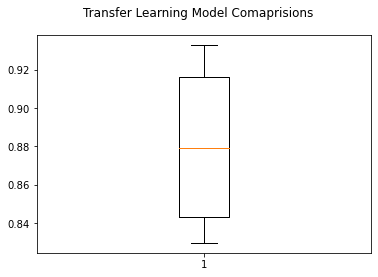

In [59]:
accuracy=[test_output_1[1],test_output_2[1],test_output_3[1],test_output_4[1]]
fig=plt.figure()
fig.suptitle('Transfer Learning Model Comaprisions')
ax=fig.add_subplot(111)
plt.boxplot(accuracy)
ax.set(xticks=models,xticklabels=models)
plt.show()